In [47]:
## Manipulación de datos
import pandas as pd
import numpy as np

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import sys

## Modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor

In [4]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv')
tienda = df.copy()
df.head()

,Order_ID,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
0,189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
1,187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
2,181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
3,197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
4,122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [5]:
df['Numero_pedidos'] = 1

In [6]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [7]:
df.sort_values(by='Order_Date',inplace=True)

In [8]:
df = df.groupby('Order_Date').sum()

In [9]:
df = df.asfreq('D')

In [10]:
df['year'] = df.index.year
df['month'] = df.index.month
df['weekofyear'] = df.index.isocalendar().week  # Para semanas del año
df['dayofweek'] = df.index.dayofweek  # 0 = Lunes, 6 = Domingo
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)  # 1 = Fin de semana

<Axes: >

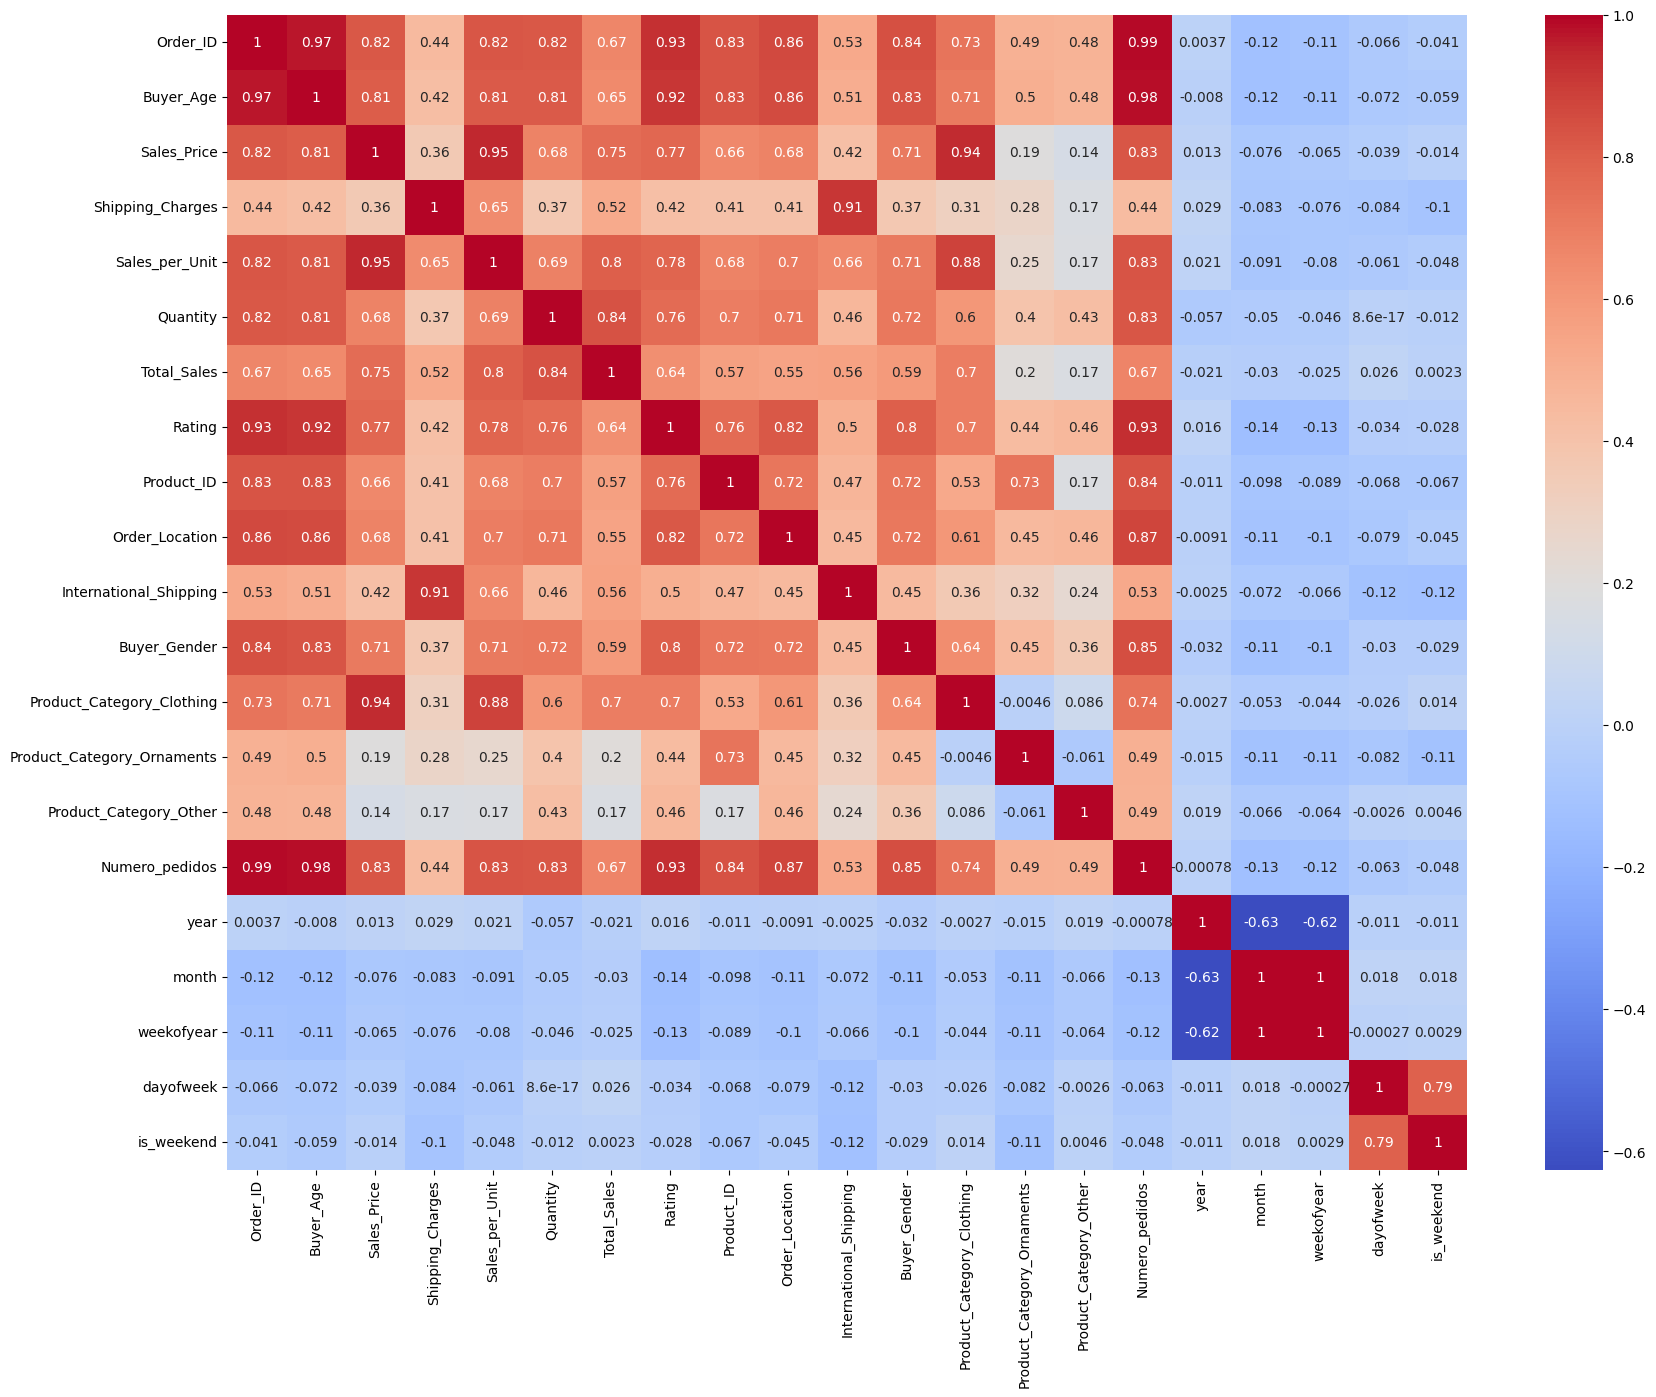

In [11]:
corr = df.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr,annot=True,cmap='coolwarm')

In [12]:
df.drop(columns=(['Buyer_Age','Sales_per_Unit','Rating','Product_ID','Order_Location','Order_ID',
                  'International_Shipping','Buyer_Gender','Product_Category_Clothing','Product_Category_Ornaments','Product_Category_Other','Sales_Price']),inplace=True)

In [13]:
df['sales_lag_1'] = df['Total_Sales'].shift(7)

df.fillna(np.mean(df['Total_Sales']),inplace=True)

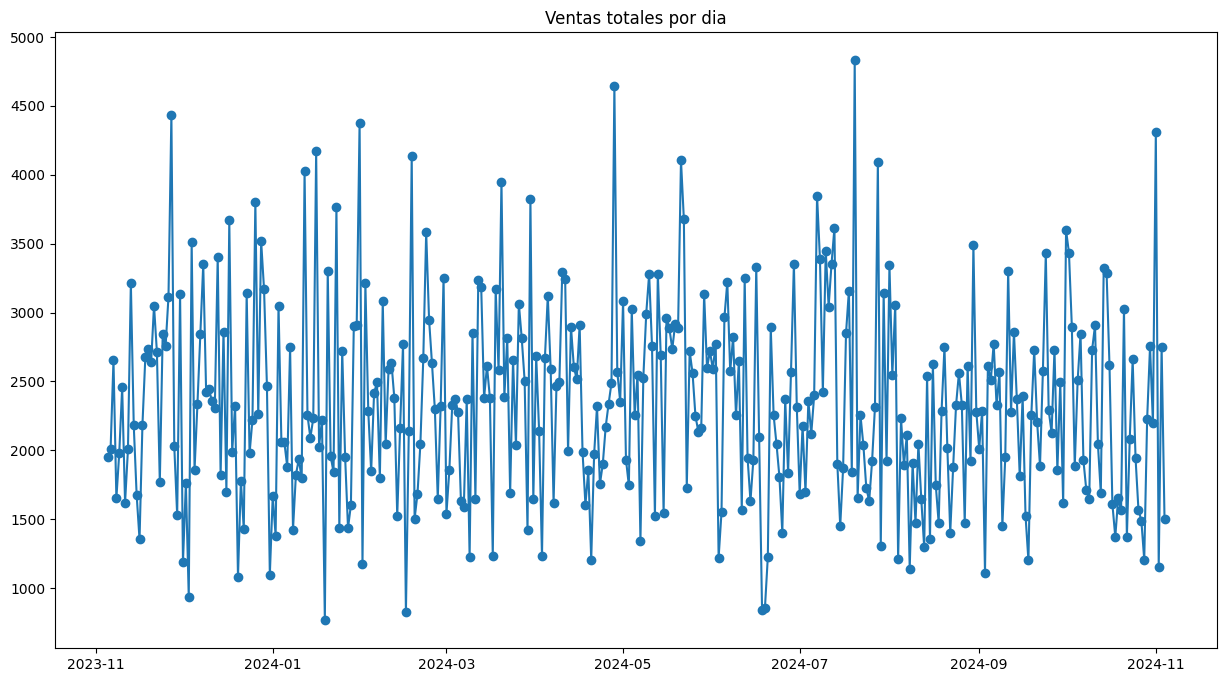

In [14]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.title('Ventas totales por dia');

In [15]:
train = df.iloc[:290]
test = df.iloc[290:]

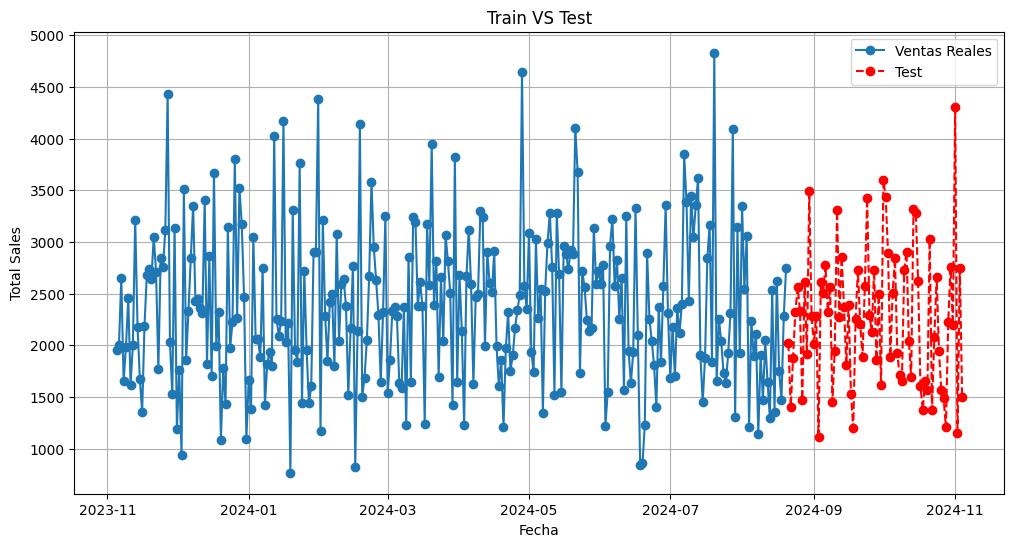

In [16]:
plt.figure(figsize=(12,6))

# Graficar las ventas reales
plt.plot(train.index, train['Total_Sales'], label='Ventas Reales', marker='o')

# Graficar predicciones en Test
plt.plot(test.index, test['Total_Sales'], label='Test', linestyle='dashed', marker='o', color='red')

# Configurar la gráfica
plt.xlabel('Fecha')
plt.ylabel('Total Sales')
plt.title('Train VS Test')
plt.legend()
plt.grid()
plt.show()

In [17]:
df.columns

Index(['Shipping_Charges', 'Quantity', 'Total_Sales', 'Numero_pedidos', 'year',
       'month', 'weekofyear', 'dayofweek', 'is_weekend', 'sales_lag_1'],
      dtype='object')

### XGBoost

In [18]:
X_train, y_train = train.drop(columns=['Total_Sales']), train['Total_Sales']
X_test, y_test = test.drop(columns=['Total_Sales']), test['Total_Sales']

In [19]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = root_mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 418.3929
MAE: 328.0691


### LGBMRegressor

In [20]:
lgb = LGBMRegressor(verbose=-1)

lgb.fit(X_train, y_train)

lgb_pred = lgb.predict(X_test)

rmse = root_mean_squared_error(y_test,lgb_pred)
mae = mean_absolute_error(y_test,lgb_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 441.6139
MAE: 340.5356


### RandomForest

In [21]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rmse = root_mean_squared_error(y_test,rf_pred)
mae = mean_absolute_error(y_test,rf_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 365.8239
MAE: 286.7534


### KNN

In [22]:
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

rmse = root_mean_squared_error(y_test,knn_pred)
mae = mean_absolute_error(y_test,knn_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 590.9502
MAE: 474.7289


### Linear regression

In [23]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

rmse = root_mean_squared_error(y_test,lr_pred)
mae = mean_absolute_error(y_test,lr_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 354.2749
MAE: 291.8018


### DecisionTreeRegressor

In [24]:
tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

tree_pred = tree.predict(X_test)

rmse = root_mean_squared_error(y_test,tree_pred)
mae = mean_absolute_error(y_test,tree_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 574.1453
MAE: 471.8553


### SVM

In [25]:
svr = SVR(kernel='linear')

svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)

rmse = root_mean_squared_error(y_test,svr_pred)
mae = mean_absolute_error(y_test,svr_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


RMSE: 352.2438
MAE: 270.8124


### STACKING

In [ ]:
stacking_clf = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor()),
        ('svr', SVR(kernel='linear'))
    ],
    final_estimator=SVR(kernel='linear'),
    cv=5  # número de folds en validación cruzada
)
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

rmse = root_mean_squared_error(y_test,stacking_pred)
mae = mean_absolute_error(y_test,stacking_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


RMSE: 347.2785
MAE: 272.2388


### Ridge

In [36]:
ridge = Ridge(solver="sag")

ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)

rmse = root_mean_squared_error(y_test,ridge_pred)
mae = mean_absolute_error(y_test,ridge_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


RMSE: 329.3694
MAE: 262.5200


### BayesianRidge

In [46]:
b_ridge = BayesianRidge()

b_ridge.fit(X_train, y_train)

b_ridge_pred = b_ridge.predict(X_test)

rmse = root_mean_squared_error(y_test,b_ridge_pred)
mae = mean_absolute_error(y_test,b_ridge_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 339.6444
MAE: 271.4333


### LASSO

In [42]:
lasso = Lasso()

lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

rmse = root_mean_squared_error(y_test,lasso_pred)
mae = mean_absolute_error(y_test,lasso_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 350.6727
MAE: 287.9087


### ElasticNet

In [ ]:
enet = ElasticNet()

enet.fit(X_train, y_train)

enet_pred = enet.predict(X_test)

rmse = root_mean_squared_error(y_test,enet_pred)
mae = mean_absolute_error(y_test,enet_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 338.9613
MAE: 270.5194
